# Imports

In [1]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AdamWeightDecay
from transformers import Trainer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import ast

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import mlflow
import mlflow.sklearn

# init

In [3]:
data_title = pd.read_csv("df_bow_title.csv")
data_tags = pd.read_csv("df_bow_tags.csv")

In [4]:
data_title=data_title.drop(['Unnamed: 0'], axis=1)
data_tags=data_tags.drop(['Unnamed: 0'], axis=1)

# Initialisation MLFlow

! PENSER A LANCER mlflow ui avant d'aller plus loin, sinon l'exécution ne se fera pas

In [116]:
mlflow.set_tracking_uri("http://localhost:5000")  # Définir l'URI de suivi de MLflow (facultatif)
mlflow.set_experiment("ML_Not_supervised_28_08")

2024/07/15 23:22:16 INFO mlflow.tracking.fluent: Experiment with name 'ML_Not_supervised_28_08' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/391409228143706010', creation_time=1721078536454, experiment_id='391409228143706010', last_update_time=1721078536454, lifecycle_stage='active', name='ML_Not_supervised_28_08', tags={}>

# Word2Vec 

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def convert_to_tags_list(df):
    return df.apply(lambda x: [df.columns[i] for i in range(len(x)) if x[i] != 0], axis=1).tolist()

tags_list = convert_to_tags_list(data_tags)
# Binariser les étiquettes
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(tags_list)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_title, y, test_size=0.2, random_state=42)
def train_and_compare_models(data_title, data_tags,X_train, X_test, y_train, y_test):

    with mlflow.start_run(run_name=f"Modèle Word2Vec"):

        # Utiliser OneVsRestClassifier pour multi-label classification
        model = OneVsRestClassifier(MultinomialNB(alpha=1.0))
        model.fit(X_train, y_train)

        # Prédire les tags pour l'ensemble de test
        y_pred = model.predict(X_test)

        # Calculer les métriques
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")
        print(classification_report(y_test, y_pred, target_names=mlb.classes_))

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_param("alpha", 1.0)
        mlflow.sklearn.log_model(model, f"model_Word2Vec")
        return y_pred,accuracy

# Appel de la fonction pour entraîner et comparer les modèles
y_pred ,accuracy=train_and_compare_models(data_title, data_tags,X_train, X_test, y_train, y_test)

C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_34644\3162631331.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df.apply(lambda x: [df.columns[i] for i in range(len(x)) if x[i] != 0], axis=1).tolist()


Accuracy: 0.15
                precision    recall  f1-score   support

            20       0.00      0.00      0.00        84
     algorithm       0.00      0.00      0.00       107
        amazon       0.00      0.00      0.00       299
       android       0.97      0.39      0.56       705
       angular       0.93      0.37      0.53       149
        apache       0.00      0.00      0.00       204
           api       1.00      0.02      0.04       280
        arrays       1.00      0.01      0.01       180
           asp       0.00      0.00      0.00       192
authentication       0.00      0.00      0.00       124
           aws       0.00      0.00      0.00       171
         azure       1.00      0.56      0.72       264
          boot       0.69      0.13      0.22       246
        chrome       0.00      0.00      0.00        77
         cloud       0.00      0.00      0.00       236
          code       0.00      0.00      0.00       172
       compose       0.97      0

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

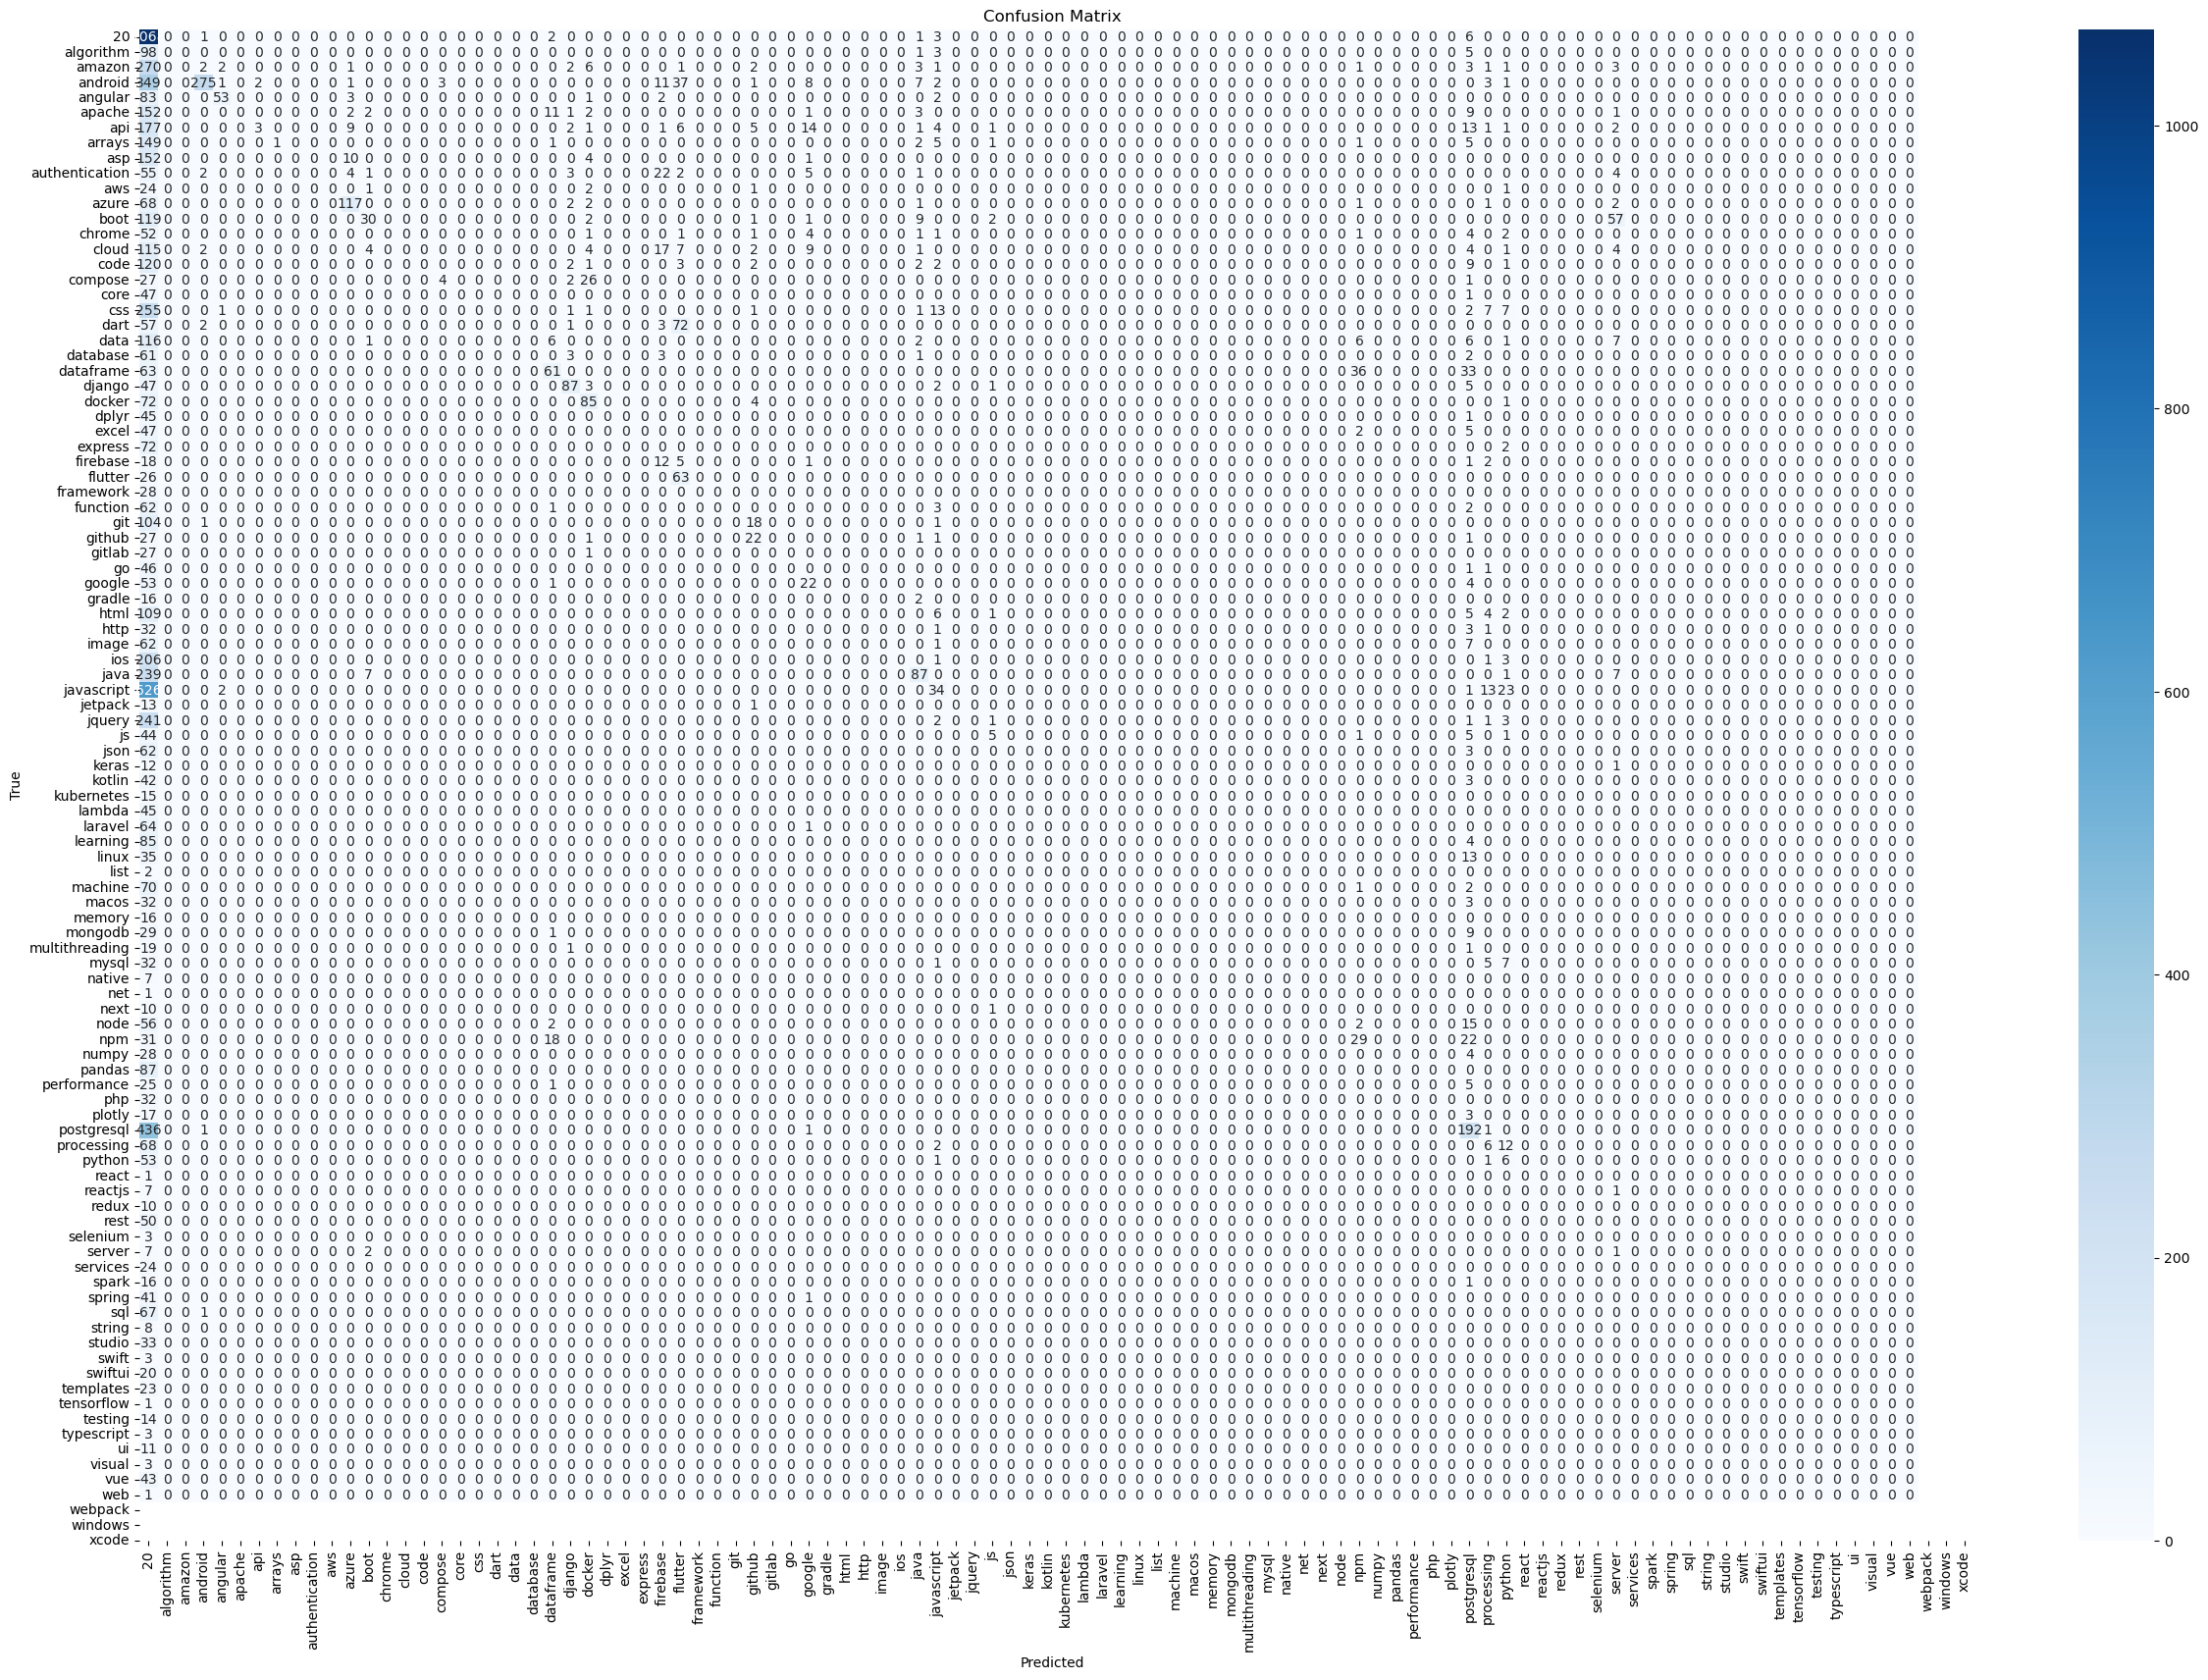

In [7]:
# Tracer la matrice de confusion
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(30, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Neural Network

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(tags_list)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_title, y, test_size=0.2, random_state=42)

# Création du modèle de réseau de neurones
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Entraînement du modèle
with mlflow.start_run(run_name=f"Modèle Neural Network"):
    mlflow.tensorflow.autolog()
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

2024/07/12 11:46:08 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2024/07/12 11:46:08 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/10
1250/1250 [==============================] - 12s 8ms/step - loss: 0.1118 - accuracy: 0.1125 - val_loss: 0.0846 - val_accuracy: 0.1680
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0816 - accuracy: 0.1838 - val_loss: 0.0811 - val_accuracy: 0.1979
Epoch 3/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0793 - accuracy: 0.1936 - val_loss: 0.0800 - val_accuracy: 0.1900
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0785 - accuracy: 0.1974 - val_loss: 0.0797 - val_accuracy: 0.1864
Epoch 5/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.0779 - accuracy: 0.1966 - val_loss: 0.0795 - val_accuracy: 0.1943
Epoch 6/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0776 - accuracy: 0.1992 - val_loss: 0.0793 - val_accuracy: 0.1891
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.0773 - accuracy: 0.1987 - val_loss: 0.0791 - val_accuracy

2024/07/12 11:47:35 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/07/12 11:47:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmpga1cuwyj\model\data\model\assets


In [9]:
y_pred_prob = model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Calculer les métriques
accuracy_adam = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_adam:.2f}")
print("Classification Report:")


313/313 [==============================] - 1s 1ms/step
Accuracy: 0.17
Classification Report:


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.00      0.00      0.00       107
           2       0.00      0.00      0.00       299
           3       0.92      0.46      0.61       705
           4       0.93      0.52      0.66       149
           5       0.00      0.00      0.00       204
           6       0.60      0.17      0.27       280
           7       0.61      0.44      0.51       180
           8       0.00      0.00      0.00       192
           9       1.00      0.04      0.08       124
          10       0.00      0.00      0.00       171
          11       1.00      0.63      0.77       264
          12       0.72      0.42      0.53       246
          13       0.00      0.00      0.00        77
          14       0.40      0.03      0.05       236
          15       0.00      0.00      0.00       172
          16       0.92      0.48      0.63       183
          17       0.00    

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

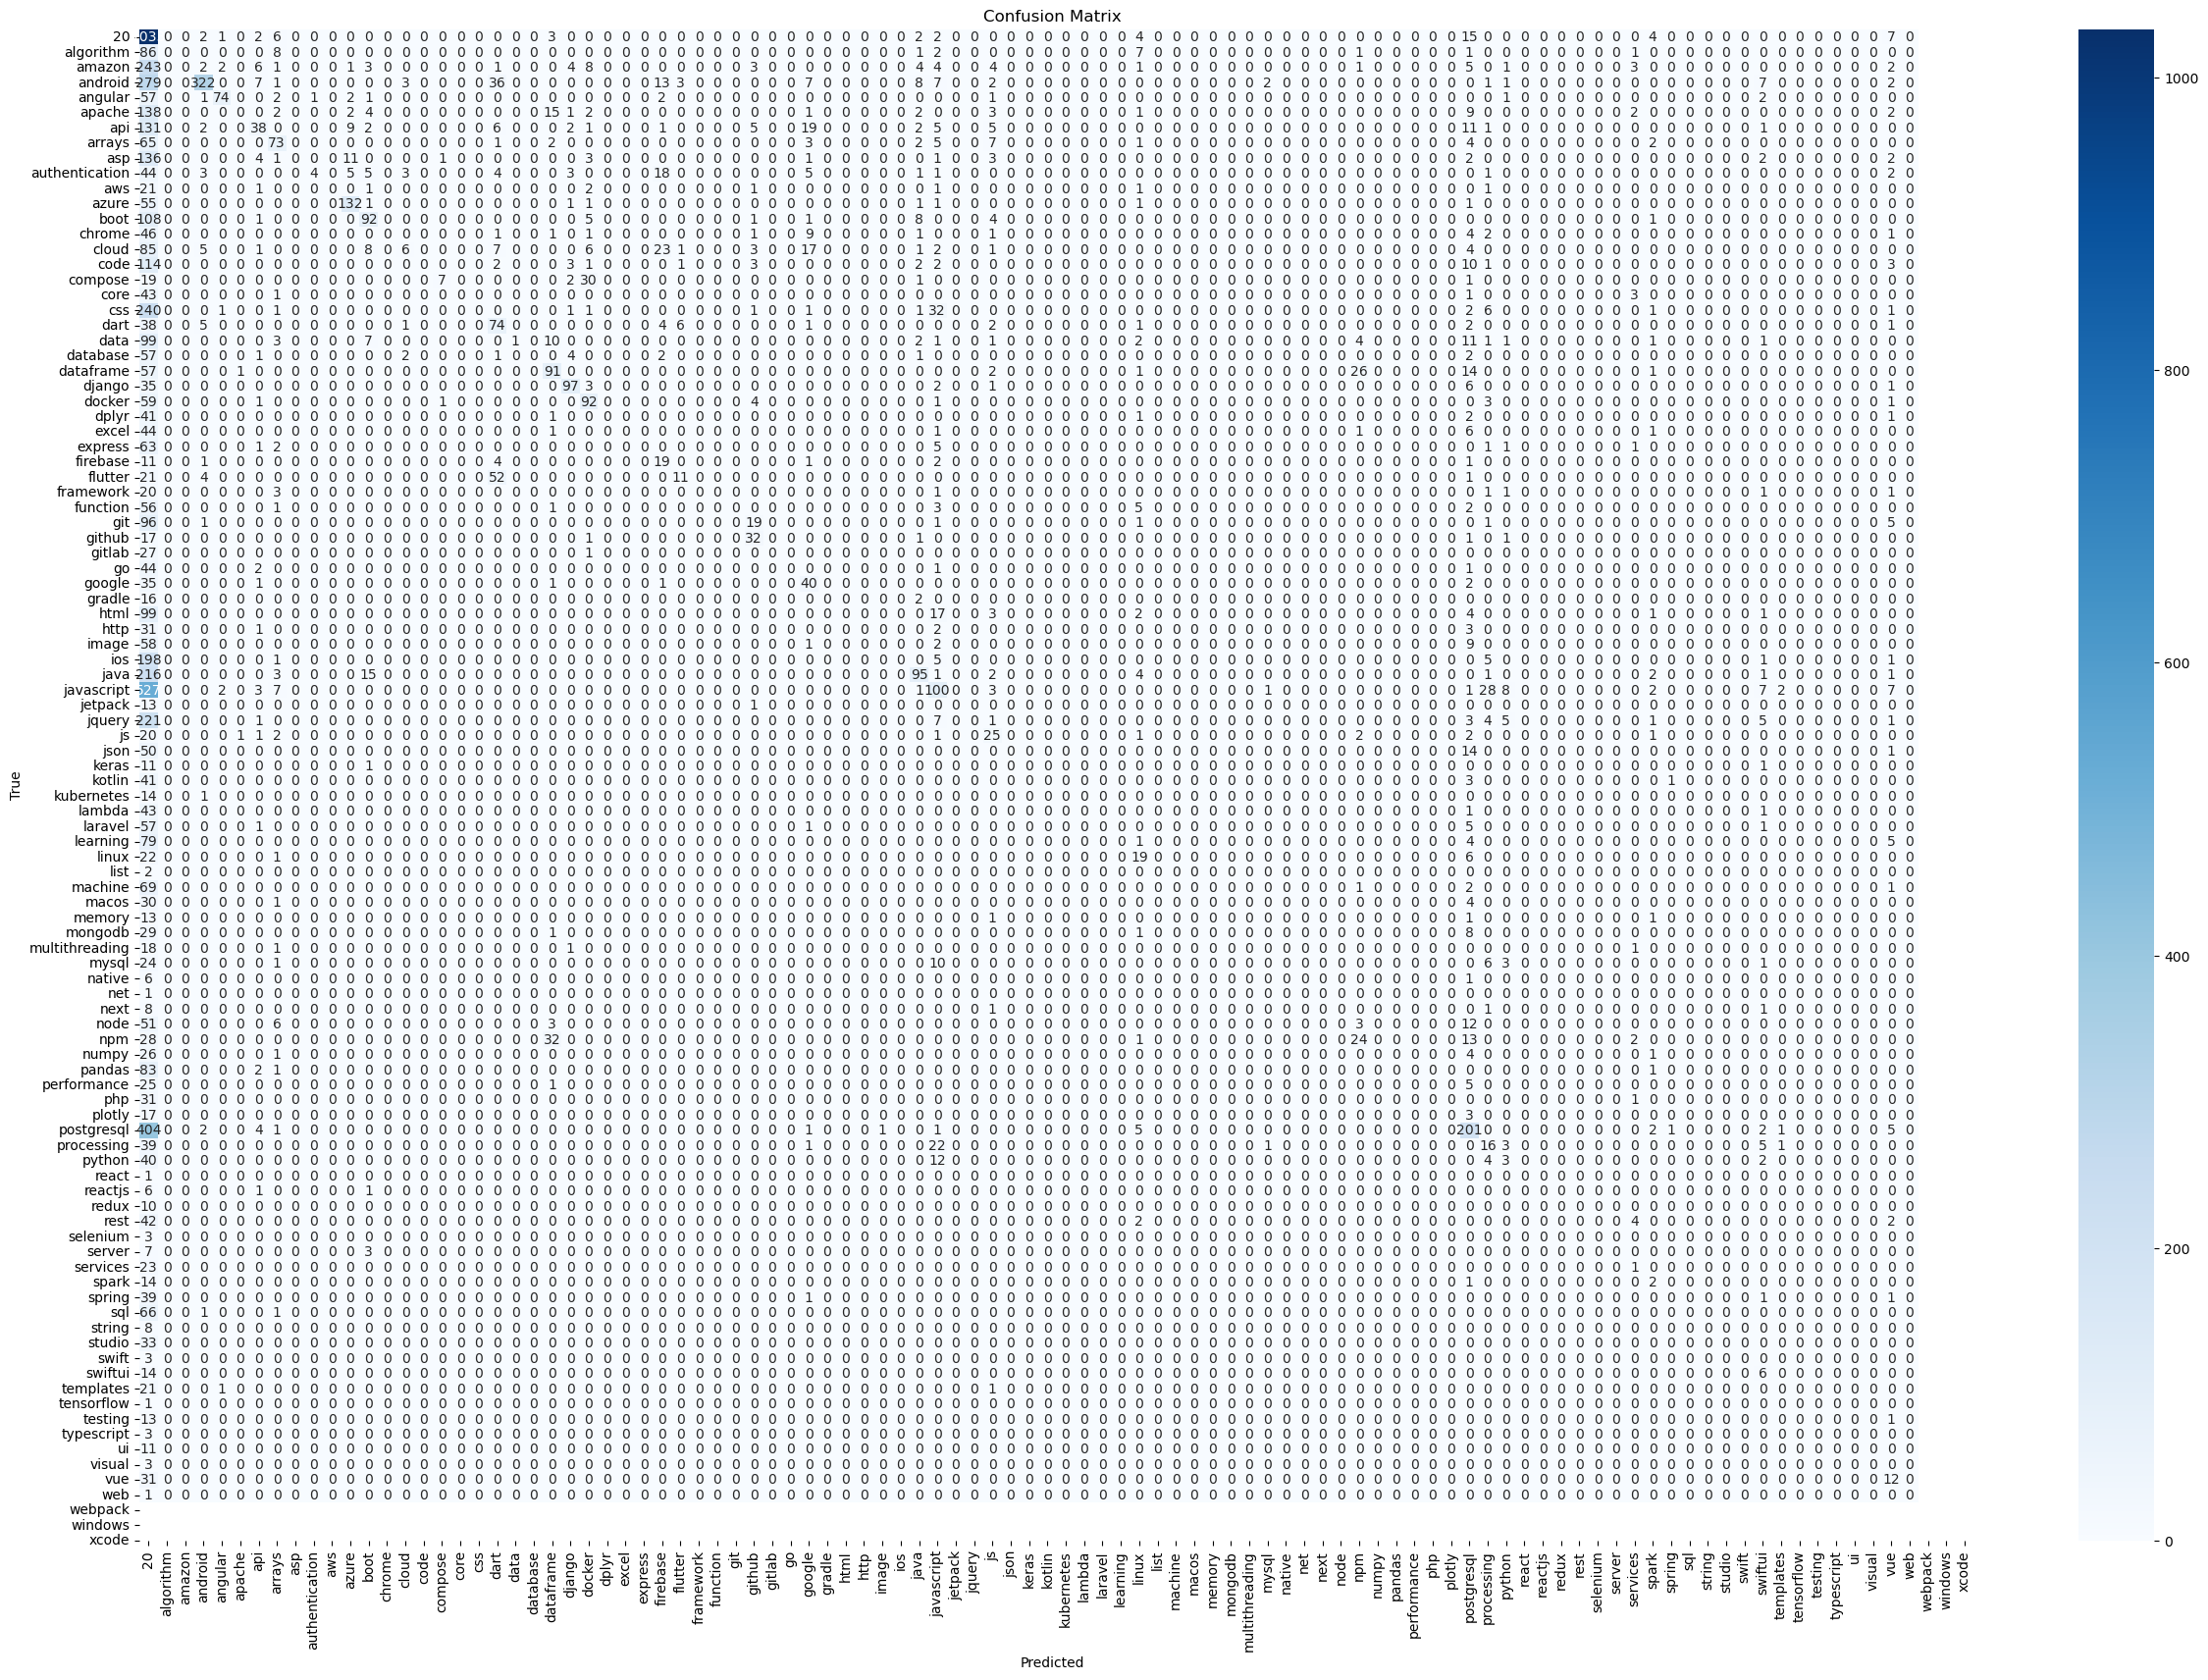

In [10]:
if accuracy_adam>accuracy:
    print(classification_report(y_test, y_pred))
    # Tracer la matrice de confusion
    conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(30, 20))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# BERT - using tfbert

Chargement des string pour Bert ainsi que passage des tags en liste

In [142]:
data_all = pd.read_csv("data_bag.csv")


In [143]:
def convert_tags(tag_str):
    """
    Convertit une chaîne de caractères représentant une liste de tags en une liste de tags.

    Args:
        tag_str (str): Chaîne de caractères représentant une liste de tags.

    Returns:
        list: Liste des tags.
    """
    tags_list = ast.literal_eval(tag_str)
    return tags_list

# Appliquer la fonction de conversion à chaque élément de la colonne 'Tags'
data_all['Tags'] = data_all['Tags'].apply(convert_tags)

On va travailler uniquement sur les 10 Tags les plus courrant

In [144]:
# Compter les occurrences de chaque tag
tag_counts = {}
for row in data_all['Tags']:
    for tag in row:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# Convertir en DataFrame pour faciliter le tri
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['tag', 'count'])

# Trier par ordre décroissant de fréquence
tag_counts_df = tag_counts_df.sort_values(by='count', ascending=False)

number_tags = 10
# Sélectionner les 100 tags les plus fréquents
top_tags = tag_counts_df.head(number_tags)['tag'].tolist()

# Filtrer les tags dans votre DataFrame d'origine pour ne garder que les 100 tags les plus fréquents
data_all['Tags'] = data_all['Tags'].apply(lambda x: [tag for tag in x if tag in top_tags])

# Afficher les 100 tags les plus fréquents
print("Les",number_tags,"tags les plus fréquents :", top_tags)

# des tags se retouvent vide => on retire les individus
data_all = data_all[data_all['Tags'].apply(len) > 0]


Les 10 tags les plus fréquents : ['python', 'javascript', 'java', 'reactjs', 'android', 'c++', 'node.js', 'r', 'c#', 'flutter']


Dans le cadre de nos tests, nous avons réduit notre ensemble pour avoir des époch bien plus courtes

In [123]:
# Run this snipet if you want to reduce the size of data_all to reduce the calculation time
#data_all = data_all.sample(frac=0.2, random_state=1)

In [145]:
data_all=data_all.drop(['Id'], axis=1)

In [146]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data_all['Tags'])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_all['Title'], y, test_size=0.2, random_state=42)

# Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encodage des textes
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Convertir en tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(8)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(8)

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [109]:
len(mlb.classes_)

10

In [126]:
from transformers import TFBertForSequenceClassification, AdamW

model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=y_train.shape[1])
# Compiler le modèle

model_bert.compile(optimizer=Adam(learning_rate=2e-5),  # Utilisation de l'identifiant en chaîne de caractères
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [127]:
with mlflow.start_run(run_name=f"bert-TF"):
    mlflow.tensorflow.autolog()
    validation_data=test_dataset,
    validation_steps=len(test_dataset),
    history = model_bert.fit(train_dataset, epochs=5, validation_data=test_dataset,validation_steps=len(test_dataset))

2024/07/15 23:27:54 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "tf_bert_for_sequence_classification_16" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/07/15 23:27:54 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dataset consists of tensors. Ragged tensors, tensor arrays, and other types are not supported. Additionally, datasets with nested tensors are not supported.
2024/07/15 23:27:54 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dataset consists of tensors. Ragged tensors, tensor arrays, and other types are not supported. Additionally, datasets 

Epoch 1/5
  6/630 [..............................] - ETA: 2:33 - loss: 0.6097 - accuracy: 0.0833WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1440s vs `on_train_batch_end` time: 0.1650s). Check your callbacks.


630/630 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.3943

2024/07/15 23:30:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/07/15 23:30:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmp8t1qyzl1\\latest_checkpoint.h5'


630/630 [==============================] - 173s 250ms/step - loss: 0.3097 - accuracy: 0.3943 - val_loss: 0.2347 - val_accuracy: 0.5488
Epoch 2/5
630/630 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.6194

2024/07/15 23:33:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/07/15 23:33:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmp8pbwwfn1\\latest_checkpoint.h5'


630/630 [==============================] - 147s 233ms/step - loss: 0.2008 - accuracy: 0.6194 - val_loss: 0.2023 - val_accuracy: 0.6037
Epoch 3/5
630/630 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.7207

2024/07/15 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/07/15 23:35:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmpkme55xdz\\latest_checkpoint.h5'


630/630 [==============================] - 162s 256ms/step - loss: 0.1501 - accuracy: 0.7207 - val_loss: 0.1900 - val_accuracy: 0.6195
Epoch 4/5
630/630 [==============================] - 114s 181ms/step - loss: 0.1119 - accuracy: 0.7932 - val_loss: 0.2014 - val_accuracy: 0.6235
Epoch 5/5
630/630 [==============================] - 129s 206ms/step - loss: 0.0877 - accuracy: 0.8278 - val_loss: 0.2124 - val_accuracy: 0.6132


1/1 [==============================] - 3s 3s/step


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmppyyti5xt\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmppyyti5xt\model\data\model\assets
2024/07/15 23:43:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/391409228143706010/9fa0836c200a4127b14d670420e6ff1f/artifacts/model/data/model/variables/variables.data-00000-of-00001 failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/391409228143706010/9fa0836c200a4127b14d670420e6ff1f/artifacts/model/data/model/variables/variables.data-00000-of-00001 (Caused by ProtocolError('Connection aborted.', ConnectionResetError(10054, 'Une connexion existante a dû être fermée par l’hôte distant', None, 10054, None)))


In [20]:
import pickle

# Sauvegarder le modèle
with open('bert_model.pkl', 'wb') as model_file:
    pickle.dump(model_bert, model_file)

# Sauvegarder le tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

INFO:tensorflow:Assets written to: ram://efac5e99-d9f2-4303-9184-5f06709a3521/assets


INFO:tensorflow:Assets written to: ram://efac5e99-d9f2-4303-9184-5f06709a3521/assets


In [21]:
from transformers import BertForSequenceClassification, BertTokenizer

# Sauvegarder le modèle et le tokenizer
model_bert.save_pretrained('./bert/model')
tokenizer.save_pretrained('./bert/tokenizer')

('./bert/tokenizer\\tokenizer_config.json',
 './bert/tokenizer\\special_tokens_map.json',
 './bert/tokenizer\\vocab.txt',
 './bert/tokenizer\\added_tokens.json')

In [22]:
# Prédire sur l'ensemble de test
y_pred_logits = model_bert.predict(test_dataset).logits
y_pred_probs = tf.nn.sigmoid(y_pred_logits)  # Appliquer sigmoid pour obtenir des probabilités
y_pred = tf.where(y_pred_probs >= 0.5, 1, 0) 

'''
# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

# Tracer la matrice de confusion pour chaque label
for i in range(y_test.shape[1]):
    conf_matrix = confusion_matrix(y_test[:, i], y_pred[:, i])
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {mlb.classes_[i]}')
    plt.show()'''

787/787 [==============================] - 51s 60ms/step


'\n# Calculer les métriques\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Accuracy: {accuracy:.2f}")\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred, target_names=mlb.classes_))\n\n# Tracer la matrice de confusion pour chaque label\nfor i in range(y_test.shape[1]):\n    conf_matrix = confusion_matrix(y_test[:, i], y_pred[:, i])\n    plt.figure(figsize=(5, 5))\n    sns.heatmap(conf_matrix, annot=True, fmt=\'d\', cmap=\'Blues\', cbar=False)\n    plt.xlabel(\'Predicted\')\n    plt.ylabel(\'True\')\n    plt.title(f\'Confusion Matrix for {mlb.classes_[i]}\')\n    plt.show()'

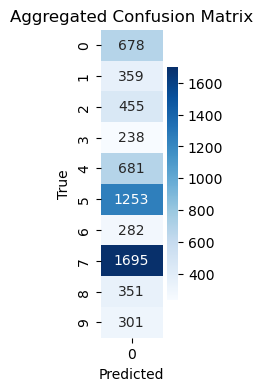

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculer la matrice de confusion pour l'ensemble de test
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Calculer la matrice de confusion agrégée en sommant sur l'axe des prédictions
aggregated_conf_matrix = conf_matrix.sum(axis=1)
# Convertir aggregated_conf_matrix en un tableau NumPy si ce n'est pas déjà le cas
aggregated_conf_matrix = np.array(aggregated_conf_matrix)

# Assurez-vous que aggregated_conf_matrix est une matrice 2D avec une seule colonne
if aggregated_conf_matrix.ndim == 1:
    aggregated_conf_matrix = aggregated_conf_matrix.reshape(-1, 1)

# Afficher la matrice de confusion agrégée avec Seaborn heatmap
plt.figure(figsize=(1, 4))
sns.heatmap(aggregated_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Aggregated Confusion Matrix')
plt.show()

In [24]:
# Fonction pour afficher les tags prédits pour une entrée spécifique
def predict_tags(title):
    encoding = tokenizer(title, truncation=True, padding=True, max_length=128, return_tensors='tf')
    logits = model_bert(encoding).logits
    probs = tf.nn.sigmoid(logits)
    print(logits)
    preds = tf.where(probs >= 0.2, 1, 0)
    predicted_tags = [mlb.classes_[i] for i in range(len(preds[0])) if preds[0][i] == 1]
    return predicted_tags

In [25]:
# Exemple de prédiction pour un nouveau titre
new_title = "synchron python process millisecond level"
predicted_tags = predict_tags(new_title)
print(new_title)
print(predicted_tags)

tf.Tensor(
[[-5.352477  -5.7699776 -5.201505  -6.312039  -5.277996  -4.7084746
  -6.0124545  4.8224077 -5.949787  -5.6989393]], shape=(1, 10), dtype=float32)
synchron python process millisecond level
['python']


# BERT - using transformers

In [140]:
data_all = pd.read_csv("data_bag.csv")
def convert_tags(tag_str):
    """
    Convertit une chaîne de caractères représentant une liste de tags en une liste de tags.

    Args:
        tag_str (str): Chaîne de caractères représentant une liste de tags.

    Returns:
        list: Liste des tags.
    """
    tags_list = ast.literal_eval(tag_str)
    return tags_list

# Appliquer la fonction de conversion à chaque élément de la colonne 'Tags'
data_all['Tags'] = data_all['Tags'].apply(convert_tags)


# Compter les occurrences de chaque tag
tag_counts = {}
for row in data_all['Tags']:
    for tag in row:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# Convertir en DataFrame pour faciliter le tri
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['tag', 'count'])

# Trier par ordre décroissant de fréquence
tag_counts_df = tag_counts_df.sort_values(by='count', ascending=False)

number_tags = 10
# Sélectionner les 100 tags les plus fréquents
top_tags = tag_counts_df.head(number_tags)['tag'].tolist()

# Filtrer les tags dans votre DataFrame d'origine pour ne garder que les 100 tags les plus fréquents
data_all['Tags'] = data_all['Tags'].apply(lambda x: [tag for tag in x if tag in top_tags])

# Afficher les 100 tags les plus fréquents
print("Les",number_tags,"tags les plus fréquents :", top_tags)

# des tags se retouvent vide => on retire les individus
data_all = data_all[data_all['Tags'].apply(len) > 0]

data_all=data_all.drop(['Id'], axis=1)

Les 10 tags les plus fréquents : ['python', 'javascript', 'java', 'reactjs', 'android', 'c++', 'node.js', 'r', 'c#', 'flutter']


In [141]:
data_reduced = data_all.sample(frac=0.5, random_state=1)

In [6]:
train_df, test_df = train_test_split(data_reduced, test_size=0.2, random_state=42)

# Extraction des textes et des tags
texts = data_reduced['Title'].tolist()
tags = data_reduced['Tags'].tolist()

# Création d'un mapping des tags à des indices
unique_tags = set(tag for sublist in tags for tag in sublist)
tag2id = {tag: i for i, tag in enumerate(unique_tags)}
id2tag = {i: tag for tag, i in tag2id.items()}

# Conversion des tags en un format binaire
labels = [[1 if tag in tag_list else 0 for tag in unique_tags] for tag_list in tags]

print(len(texts))
print(len(tags))
print(len(labels))
print(len(unique_tags))

# Vérification des premières entrées
print("\nExamples:")
print("Text:", texts[0])
print("Tags:", tags[0])
print("Binary Labels:", labels[0])

15732
15732
15732
10

Examples:
Text: spread singl column wide format valu defin condit
Tags: ['r']
Binary Labels: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [7]:
# Chargement du tokenizer BERT
model_path = './model-FINAL/'
tokenizer = BertTokenizer.from_pretrained(model_path)

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=len(unique_tags),
    id2label=id2tag,
    label2id=tag2id,
    problem_type="multi_label_classification"
)


In [8]:
# Encodage des textes
encoded_texts = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors='pt')

In [9]:
# Création du dataset
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float) 

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    
dataset = TextDataset(encoded_texts, labels)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
# Partitionner le dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Nombre d'exemples dans le dataset d'entraînement : {len(train_dataset)}")
print(f"Nombre d'exemples dans le dataset de test : {len(test_dataset)}")

Nombre d'exemples dans le dataset d'entraînement : 11012
Nombre d'exemples dans le dataset de test : 4720


In [10]:
# Itération à travers les batches
for batch in test_dataset:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    
    # Affichage des dimensions des tensors dans le batch
    print(f"Input IDs shape: {input_ids.shape}")
    print(f"Attention mask shape: {attention_mask.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # Affichage des premiers exemples dans le batch
    print("Premier exemple dans le batch :")
    print(f"Input IDs : {input_ids}")
    print(f"Input IDs type : {input_ids.dtype}")
    print(f"Attention mask : {attention_mask}")
    print(f"Labels : {labels}")
    print(f"Labels type : {labels.dtype}")
    
    break

Input IDs shape: torch.Size([53])
Attention mask shape: torch.Size([53])
Labels shape: torch.Size([10])
Premier exemple dans le batch :
Input IDs : tensor([  101,  2448,  6170,  2140,  7399, 19723,  8303,  2408,  4800, 24759,
        13075,  2401, 16558,  2177,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])
Input IDs type : torch.int64
Attention mask : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])
Labels : tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Labels type : torch.float32


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [12]:
#Current test
def compute_metrics(pred):
    labels = pred.label_ids
    logits = pred.predictions

    # Convertir les logits en prédictions binaires
    threshold = 0.5
    preds = (logits > threshold).astype(float)

    # Calcul des métriques par exemple pour chaque classe
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    acc = accuracy_score(labels, preds)


    # Afficher quelques exemples pour vérification
    #print("Sample Predictions and Labels:")
    '''for i in range(1):  # Afficher les 5 premiers exemples
        print(f"logits: {logits[i]}")
        print(f"Predictions: {preds[i]}")
        print(f"Labels: {labels[i]}")
        #print(precision)
        #print(recall)
        #print(f1)
        #print(acc)'''

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

In [15]:
# Définissez votre fonction de perte comme CrossEntropyLoss
loss_fn = torch.nn.BCEWithLogitsLoss()


training_args = TrainingArguments(
    output_dir="./my_model_trans_2",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
)

# Utiliser un data collator avec padding automatique
data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,  
    compute_metrics=compute_metrics,
)

e:\Users\Beast-Of-War\miniconda3\envs\tf2_10\lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [16]:
trainer.train()

  0%|          | 0/5512 [00:00<?, ?it/s]C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
  9%|▉         | 500/5512 [16:42<2:42:37,  1.95s/it]

{'loss': 0.2032, 'learning_rate': 1.8185776487663284e-05, 'epoch': 0.73}


                                                    
 12%|█▎        | 689/5512 [25:44<2:24:22,  1.80s/it]

{'eval_loss': 0.16612310707569122, 'eval_accuracy': 0.5173728813559322, 'eval_f1': 0.6685063815108658, 'eval_precision': 0.8870918523039365, 'eval_recall': 0.5363468634686347, 'eval_runtime': 158.3408, 'eval_samples_per_second': 29.809, 'eval_steps_per_second': 1.863, 'epoch': 1.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 18%|█▊        | 1000/5512 [35:55<2:26:14,  1.94s/it]

{'loss': 0.1558, 'learning_rate': 1.6371552975326563e-05, 'epoch': 1.45}


                                                     
 25%|██▌       | 1378/5512 [50:45<1:52:00,  1.63s/it]

{'eval_loss': 0.15422089397907257, 'eval_accuracy': 0.574364406779661, 'eval_f1': 0.7130678752562858, 'eval_precision': 0.8588510527683909, 'eval_recall': 0.6095940959409594, 'eval_runtime': 154.3408, 'eval_samples_per_second': 30.582, 'eval_steps_per_second': 1.911, 'epoch': 2.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 27%|██▋       | 1500/5512 [54:47<2:10:15,  1.95s/it] 

{'loss': 0.1342, 'learning_rate': 1.4557329462989842e-05, 'epoch': 2.18}


 36%|███▋      | 2000/5512 [1:10:57<1:52:50,  1.93s/it]

{'loss': 0.1148, 'learning_rate': 1.274310595065312e-05, 'epoch': 2.9}


                                                       
 38%|███▊      | 2067/5512 [1:15:40<1:33:45,  1.63s/it]

{'eval_loss': 0.1560116559267044, 'eval_accuracy': 0.5915254237288136, 'eval_f1': 0.7180411278354887, 'eval_precision': 0.843796711509716, 'eval_recall': 0.6249077490774908, 'eval_runtime': 153.2834, 'eval_samples_per_second': 30.793, 'eval_steps_per_second': 1.925, 'epoch': 3.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 45%|████▌     | 2500/5512 [1:30:08<3:04:58,  3.68s/it] 

{'loss': 0.0951, 'learning_rate': 1.0928882438316401e-05, 'epoch': 3.63}


                                                       
 50%|█████     | 2756/5512 [1:42:33<1:23:53,  1.83s/it]

{'eval_loss': 0.16296261548995972, 'eval_accuracy': 0.6082627118644067, 'eval_f1': 0.7191802090880861, 'eval_precision': 0.8191464277293091, 'eval_recall': 0.6409594095940959, 'eval_runtime': 170.8808, 'eval_samples_per_second': 27.622, 'eval_steps_per_second': 1.726, 'epoch': 4.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 54%|█████▍    | 3000/5512 [1:51:48<1:32:05,  2.20s/it] 

{'loss': 0.082, 'learning_rate': 9.114658925979682e-06, 'epoch': 4.35}


                                                       
 62%|██████▎   | 3445/5512 [2:11:06<1:05:11,  1.89s/it]

{'eval_loss': 0.17395968735218048, 'eval_accuracy': 0.6273305084745763, 'eval_f1': 0.7311655827913957, 'eval_precision': 0.7986885245901639, 'eval_recall': 0.674169741697417, 'eval_runtime': 170.1515, 'eval_samples_per_second': 27.74, 'eval_steps_per_second': 1.734, 'epoch': 5.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 63%|██████▎   | 3500/5512 [2:13:13<1:11:28,  2.13s/it] 

{'loss': 0.0757, 'learning_rate': 7.300435413642961e-06, 'epoch': 5.08}


 73%|███████▎  | 4000/5512 [2:31:38<49:38,  1.97s/it]  

{'loss': 0.0629, 'learning_rate': 5.486211901306241e-06, 'epoch': 5.81}


                                                       
 75%|███████▌  | 4134/5512 [2:38:38<38:45,  1.69s/it]

{'eval_loss': 0.17976020276546478, 'eval_accuracy': 0.6338983050847458, 'eval_f1': 0.729921181283049, 'eval_precision': 0.7946991092765587, 'eval_recall': 0.6749077490774907, 'eval_runtime': 154.0256, 'eval_samples_per_second': 30.644, 'eval_steps_per_second': 1.915, 'epoch': 6.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 82%|████████▏ | 4500/5512 [2:50:47<33:37,  1.99s/it]   

{'loss': 0.0563, 'learning_rate': 3.671988388969521e-06, 'epoch': 6.53}


                                                     
 88%|████████▊ | 4823/5512 [3:04:05<18:52,  1.64s/it]

{'eval_loss': 0.18381653726100922, 'eval_accuracy': 0.636864406779661, 'eval_f1': 0.7377448591755189, 'eval_precision': 0.78186325139434, 'eval_recall': 0.698339483394834, 'eval_runtime': 153.3395, 'eval_samples_per_second': 30.781, 'eval_steps_per_second': 1.924, 'epoch': 7.0}


C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_18428\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
 91%|█████████ | 5000/5512 [3:10:05<17:18,  2.03s/it]  

{'loss': 0.0526, 'learning_rate': 1.8577648766328013e-06, 'epoch': 7.26}


100%|█████████▉| 5500/5512 [3:27:39<00:23,  1.96s/it]

{'loss': 0.0471, 'learning_rate': 4.3541364296081276e-08, 'epoch': 7.98}


                                                     
100%|██████████| 5512/5512 [3:30:44<00:00,  1.78s/it]

{'eval_loss': 0.18528468906879425, 'eval_accuracy': 0.6358050847457627, 'eval_f1': 0.7350695124339143, 'eval_precision': 0.7830621610346267, 'eval_recall': 0.6926199261992619, 'eval_runtime': 160.7695, 'eval_samples_per_second': 29.359, 'eval_steps_per_second': 1.835, 'epoch': 8.0}


100%|██████████| 5512/5512 [3:30:49<00:00,  2.29s/it]

{'train_runtime': 12649.8796, 'train_samples_per_second': 6.964, 'train_steps_per_second': 0.436, 'train_loss': 0.0980692910698225, 'epoch': 8.0}


TrainOutput(global_step=5512, training_loss=0.0980692910698225, metrics={'train_runtime': 12649.8796, 'train_samples_per_second': 6.964, 'train_steps_per_second': 0.436, 'train_loss': 0.0980692910698225, 'epoch': 8.0})

In [13]:
# Évaluer votre modèle sur l'ensemble de test
eval_results = trainer.evaluate(eval_dataset=test_dataset)

C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_23596\1910119733.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key != 'token_type_ids'}
C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_23596\1910119733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
100%|██████████| 295/295 [03:00<00:00,  1.63it/s]


In [27]:
def predict_tags(texts, model, tokenizer, threshold=0.5):
    # Tokenizer les textes
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Faire des prédictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Appliquer une fonction sigmoïde aux logits pour obtenir des probabilités
    probs = torch.sigmoid(outputs.logits)
    print(probs)

    # Convertir les probabilités en tags (en utilisant un seuil de 0.5 par défaut)
    predicted_tags = (probs > threshold).int()

    # Convertir les indices des tags en noms de tags
    tag_names = []
    for tags in predicted_tags:
        tag_names.append([model.config.id2label[i] for i, tag in enumerate(tags) if tag == 1])

    return tag_names

In [31]:
test_texts = [
    "error while loading javascript",
    "gener possibl uniqu peptid permut python"
]

# Obtenir les tags pour les textes de test
predicted_tags = predict_tags(test_texts,model,tokenizer,0.5)

# Afficher les résultats
for text, tags in zip(test_texts, predicted_tags):
    print(f"Text: {text}")
    print(f"Predicted tags: {tags}")

tensor([[0.0086, 0.0774, 0.0037, 0.0076, 0.0075, 0.0053, 0.9965, 0.0644, 0.0075,
         0.0038],
        [0.0032, 0.0042, 0.0023, 0.0025, 0.9962, 0.0073, 0.0036, 0.0037, 0.0024,
         0.0033]])
Text: error while loading javascript
Predicted tags: ['javascript']
Text: gener possibl uniqu peptid permut python
Predicted tags: ['python']


# QA

In [147]:
data_all_reduced_QA = data_all.sample(frac=0.25, random_state=1)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data_all_reduced_QA['Tags'])
print("Tags après binarisation:", mlb.classes_)

Tags après binarisation: ['android' 'c#' 'c++' 'flutter' 'java' 'javascript' 'node.js' 'python' 'r'
 'reactjs']


In [148]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from transformers import TFAutoModelForSequenceClassification


In [149]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
model = TFAutoModelForSequenceClassification.from_pretrained('sentence-transformers/multi-qa-MiniLM-L6-cos-v1', num_labels=len(top_tags))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [150]:
# Tokenizer les textes
X = tokenizer(data_all['Title'].tolist(), padding=True, truncation=True, return_tensors="tf")

In [151]:
# Convertir les étiquettes binarisées en tenseurs
y = tf.convert_to_tensor(y, dtype=tf.float32)

In [152]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 0.5*2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [153]:
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy', f1_m, recall_m])

In [154]:
with mlflow.start_run(run_name=f"Modèle QA"):
    mlflow.tensorflow.autolog()

    history = model.fit(
        train_dataset,
        epochs=10,
        batch_size=4,
        validation_data=test_dataset,
        validation_steps=len(test_dataset),
    )

2024/07/15 23:51:37 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "tf_bert_for_sequence_classification_18" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2024/07/15 23:51:38 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dataset consists of tensors. Ragged tensors, tensor arrays, and other types are not supported. Additionally, datasets with nested tensors are not supported.
2024/07/15 23:51:39 WARNING mlflow.data.tensorflow_dataset: Failed to infer schema for TensorFlow dataset. Exception: Failed to infer schema for tf.data.Dataset. Schemas can only be inferred if the dataset consists of tensors. Ragged tensors, tensor arrays, and other types are not supported. Additionally, datasets 

Epoch 1/10
3147/3147 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.4713 - f1_m: 0.1506 - recall_m: 0.1088

2024/07/15 23:56:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/07/15 23:56:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmpx70_5z8m\\latest_checkpoint.h5'


3147/3147 [==============================] - 312s 96ms/step - loss: 0.3168 - accuracy: 0.4713 - f1_m: 0.1506 - recall_m: 0.1088 - val_loss: 0.2262 - val_accuracy: 0.5744 - val_f1_m: 0.2714 - val_recall_m: 0.2118
Epoch 2/10
3147/3147 [==============================] - 301s 96ms/step - loss: 0.2911 - accuracy: 0.4285 - f1_m: 0.1634 - recall_m: 0.1191 - val_loss: 0.2670 - val_accuracy: 0.4238 - val_f1_m: 0.2042 - val_recall_m: 0.1451
Epoch 3/10
3147/3147 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.5469 - f1_m: 0.2351 - recall_m: 0.1786

2024/07/16 00:06:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/07/16 00:06:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmposa7m5_p\\latest_checkpoint.h5'


3147/3147 [==============================] - 305s 97ms/step - loss: 0.2646 - accuracy: 0.5469 - f1_m: 0.2351 - recall_m: 0.1786 - val_loss: 0.2359 - val_accuracy: 0.5420 - val_f1_m: 0.2419 - val_recall_m: 0.1815
Epoch 4/10
3147/3147 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.4340 - f1_m: 0.1442 - recall_m: 0.1049

2024/07/16 00:11:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/07/16 00:11:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmp9nuof9vf\\latest_checkpoint.h5'


3147/3147 [==============================] - 293s 93ms/step - loss: 0.3374 - accuracy: 0.4340 - f1_m: 0.1442 - recall_m: 0.1049 - val_loss: 0.2357 - val_accuracy: 0.5257 - val_f1_m: 0.2389 - val_recall_m: 0.1802
Epoch 5/10
3147/3147 [==============================] - 309s 98ms/step - loss: 0.3237 - accuracy: 0.4383 - f1_m: 0.1825 - recall_m: 0.1352 - val_loss: 0.3955 - val_accuracy: 0.5851 - val_f1_m: 0.2247 - val_recall_m: 0.1615
Epoch 6/10
3147/3147 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.5196 - f1_m: 0.2250 - recall_m: 0.1688

2024/07/16 00:22:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/07/16 00:22:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmpbcxpe61u\\latest_checkpoint.h5'


3147/3147 [==============================] - 309s 98ms/step - loss: 0.2920 - accuracy: 0.5196 - f1_m: 0.2250 - recall_m: 0.1688 - val_loss: 0.2274 - val_accuracy: 0.5819 - val_f1_m: 0.2856 - val_recall_m: 0.2279
Epoch 7/10
3147/3147 [==============================] - 338s 107ms/step - loss: 0.2305 - accuracy: 0.5830 - f1_m: 0.2773 - recall_m: 0.2242 - val_loss: 0.2445 - val_accuracy: 0.6490 - val_f1_m: 0.3279 - val_recall_m: 0.2858
Epoch 8/10
3147/3147 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.6159 - f1_m: 0.2926 - recall_m: 0.2374

2024/07/16 00:33:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/07/16 00:33:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmpeaalamyp\\latest_checkpoint.h5'


3147/3147 [==============================] - 343s 109ms/step - loss: 0.2251 - accuracy: 0.6159 - f1_m: 0.2926 - recall_m: 0.2374 - val_loss: 0.2145 - val_accuracy: 0.6406 - val_f1_m: 0.3377 - val_recall_m: 0.2924
Epoch 9/10
3147/3147 [==============================] - 335s 106ms/step - loss: 0.2325 - accuracy: 0.6152 - f1_m: 0.2631 - recall_m: 0.2170 - val_loss: 0.2381 - val_accuracy: 0.6291 - val_f1_m: 0.3241 - val_recall_m: 0.2826
Epoch 10/10
3147/3147 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.6512 - f1_m: 0.3252 - recall_m: 0.2786

2024/07/16 00:44:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
2024/07/16 00:44:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 2] No such file or directory: 'C:\\Users\\BEAST-~1\\AppData\\Local\\Temp\\tmp75dg3mx6\\latest_checkpoint.h5'


1/1 [==============================] - 2s 2s/step


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmp6lxbgztq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmp6lxbgztq\model\data\model\assets
2024/07/16 00:45:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\BEAST-~1\AppData\Local\Temp\tmp6lxbgztq\model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.1']. Set logging level to DEBUG to see the full traceback. 


In [38]:
# Nouveau texte à classifier
new_texts = ["youtub ifram work googl interact canva load googl", "discord python ad user input command use choic oppos wait_for"]

# Tokenizer les nouveaux textes
new_X = tokenizer(new_texts, padding=True, truncation=True, return_tensors="tf")

# Faire des prédictions
predictions = model.predict(new_X.data)

# Convertir les prédictions en tags
predicted_tags = mlb.inverse_transform(predictions.logits > 0.1)

# Afficher les prédictions avec les scores
for i, text in enumerate(new_texts):
    print(f"Texte: {text}")
    print(f"Tags prédits: {predicted_tags[i]}")
    print(f"Scores de prédiction:")
    for tag, score in zip(mlb.classes_, predictions.logits[i]):
        if score >0:
            print(f"{tag}: {score:.4f}")
    print()

1/1 [==============================] - 2s 2s/step
Texte: youtub ifram work googl interact canva load googl
Tags prédits: ('javascript', 'node.js', 'reactjs')
Scores de prédiction:
javascript: 1.0002
node.js: 0.2684
reactjs: 0.1974

Texte: discord python ad user input command use choic oppos wait_for
Tags prédits: ('python',)
Scores de prédiction:
python: 1.2230



In [39]:
X = tokenizer(data_all_reduced_QA['Title'].tolist(), padding=True, truncation=True, return_tensors="tf")

# Faire des prédictions
predictions = model.predict(X.data)

# Enregistrer les prédictions dans data_all_reduced_QA["QA_predict"]
data_all_reduced_QA["QA_predict"] = predictions.logits.argmax(axis=1)

246/246 [==============================] - 12s 46ms/step
